<img src="https://upload.wikimedia.org/wikipedia/fr/8/81/Sciences_SU.png" width="240" height="240" align="center"/>


# RNN-LSTM et architectures avancées [Analyse de sentiment]

In [41]:
# Dans ce notebook, nous allons nous intéresser à des tâches d'analyse de sentiments
# -> c'est à dire prédire un label de sentiment (ici positif ou négatif) à partir d'un texte

# Ce notebook vise à approfondir : 
# - L'application du DL sur des données textuelles
# - La compréhension des architectures RNN avancées comme les LSTM et les mécanismes d'attention
#

# 1. Importation des modules

In [42]:
# On importe les librairies usuelless
import math
import numpy as np
import matplotlib.pyplot as plt

# On désactive les warnings
import warnings
warnings.filterwarnings('ignore')


## 1. Charger les données

## 2. Formater/Préparer les données

In [43]:
# On charge directement la base IMDB par les datasets de Keras
# La méthode load_date possède pas mal d'options et de propriétés intéressantes (voir description) :
# 1) Sépare les jeux d'entrainement et de test
# 2) num_words : Top most frequent words to consider.
# 3) skip_top : Top most frequent words to ignore (they will appear as oov_char value in the sequence data).
# 4) maxlen : Maximum sequence length. Any longer sequence will be truncated.
# 5) seed : Seed for reproducible data shuffling.
# 6) start_char : The start of a sequence will be marked with this character. Set to 1 because 0 is usually the padding character.
# 7) oov_char : words that were cut out because of the num_words or skip_top limit will be replaced with this character.
# 8) index_from : Index actual words with this index and higher.

from tensorflow.keras.datasets import imdb

num_words = 5000
max_len   =  100

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words,
                                                      maxlen=max_len)
                                            

In [44]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# On padde les séquences

print("La phrase avant padding est : \n {}". format(x_train[0]))

# On padde les séquence de mot
max_len       = 100
x_train       = pad_sequences(x_train, maxlen=max_len, truncating='post')
x_test        = pad_sequences(x_test, maxlen=max_len, truncating='post')

print("La phrase paddée sur une longueur {} est : \n {}". format(max_len, x_train[0]))
      
print(len(x_train))    

La phrase avant padding est : 
 [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 2, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]
La phrase paddée sur une longueur 100 est : 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  778  128   74   12  630  163   15    4 1766    2 1051    2
   32   85  156   45   40  148  139  121  664  665   10   10 1361  173
    4  749    2   16 3804    8    4  226   65   12   43  127   24    2
   10   10]
2773


## 3. Déclaration du réseau

La tâche consiste à prédire la valence d'un texte à partir de son contenu.
Pour ce faire nous allons créer une architecture many-to-one 
avec les réseaux RNNs
Le problème consiste à implémenter et apprendre
des réseaux avec - par exemple - les configurations suivantes : 
On va comparer les configurations suivantes : 
- Simple RNN avec dropout (avec un taux de 25% en sortie du RNN)
- RNN-LSTM gauche-droite classique
- LSTM bi-directionnel et return_sequences = False
- Plusieurs couches au choix. On veillera en particulier 
  à la valeur des arguments return_sequences
  
Dans le rapport à faire directement dans le notebook, on prendra soin de :
- reporter les losses sur les ensembles d'entrainement et de validation
- mesurer l'accuracy sur l'ensemble de test
On commentera les résultats obtenus en comparant les configurations
Quelle est la configuration donnant la meilleure performance ? 
Pourquoi ?

Aide : une couche LSTM bi-directionnelle est obtenue en appliquant sur la même couche une couche LSTM et une couche Bidirectional

In [45]:
# On importe les librairies pour le RNN
from tensorflow.keras.layers import Dense , Input , SimpleRNN, LSTM , Embedding, Dropout
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
#from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 28

# Example d'architecture pour le réseau RNN simple avec dropout
model = Sequential()
model.add(Embedding(num_words, embed_size))                 # layer embedding
model.add(SimpleRNN(RNN_size, return_sequences = False))    # layer RNN
model.add(Dropout(0.25))                                    # layer Dropout
model.add(Dense(1))                                         # layer Dense

# On affiche l'architecture de notre modèle
model.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         640000    
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 28)                4396      
                                                                 
 dropout_5 (Dropout)         (None, 28)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 29        
                                                                 
Total params: 644,425
Trainable params: 644,425
Non-trainable params: 0
_________________________________________________________________


## 4. Entrainement du réseau

In [46]:
# On entraine le réseau
batch_size = 64                                                             # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 9s 89ms/step - loss: 1.2113 - accuracy: 0.5266 - val_loss: 0.6930 - val_accuracy: 0.6198
Epoch 2/10
35/35 [==============================] - 2s 66ms/step - loss: 0.4607 - accuracy: 0.8440 - val_loss: 0.6094 - val_accuracy: 0.7243
Epoch 3/10
35/35 [==============================] - 2s 57ms/step - loss: 0.2208 - accuracy: 0.9445 - val_loss: 1.0011 - val_accuracy: 0.7297
Epoch 4/10
35/35 [==============================] - 2s 56ms/step - loss: 0.0842 - accuracy: 0.9824 - val_loss: 1.7806 - val_accuracy: 0.7243
Epoch 5/10
35/35 [==============================] - 2s 46ms/step - loss: 0.0601 - accuracy: 0.9928 - val_loss: 1.0091 - val_accuracy: 0.7459
Epoch 6/10
35/35 [==============================] - 2s 44ms/step - loss: 0.0574 - accuracy: 0.9896 - val_loss: 1.3175 - val_accuracy: 0.6919
Epoch 7/10
35/35 [==============================] - 2s 44ms/step - loss: 0.0389 - accuracy: 0.9946 - val_loss: 1.2484 - val_accuracy: 0.7243
Epoch 8/10
35

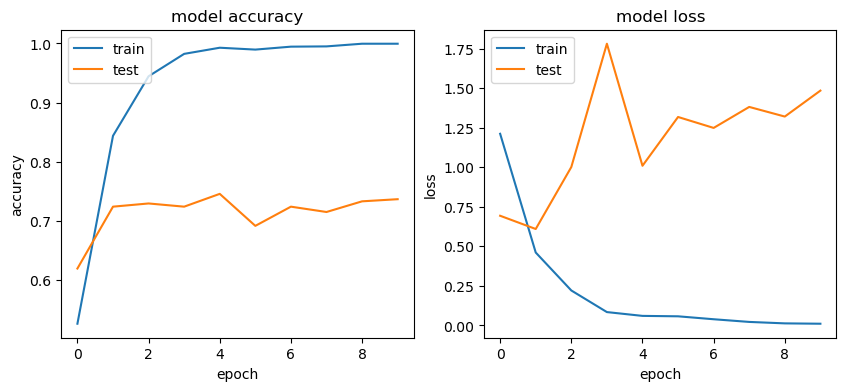

In [47]:
# On trace la loss et l'accuracy du modèle

def plotTrainingHistory(history):
    # On trace l'évolution de l'accuracy
    plt.figure(figsize= (10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy']) 
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.show()
    # On trace l'évolution de la loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.show()
    
plotTrainingHistory(history)

In [48]:
history

# On prédit sur l'ensemble de test

# On prédit sur les données de test
y_hat = model.predict(x_test)

# On tranforme les prédictions en labels
i_pos = [i for i in range(len(y_hat)) if y_hat[i]>0]
i_neg = [i for i in range(len(y_hat)) if y_hat[i]<=0]

y_pred   = np.zeros(len(y_hat))
y_pred[i_pos] = 1
y_pred[i_neg] = 0


93/93 [==============================] - 2s 12ms/step


In [21]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)


La matrice de confusion sur le jeu de test :
 [[ 313 1046]
 [ 186 1418]] 

L accuracy sur le jeu de test est :
 0.5842051974350321


# LSTM

In [49]:
embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 28

# Example d'architecture pour le réseau RNN simple avec dropout
model = Sequential()
model.add(Embedding(num_words, embed_size))                 # layer embedding
model.add(SimpleRNN(RNN_size, return_sequences = False))    # layer RNN
model.add(Dropout(0.25))                                    # layer Dropout
model.add(Dense(1))                                         # layer Dense

# On affiche l'architecture de notre modèle
model.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 128)         640000    
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 28)                4396      
                                                                 
 dropout_6 (Dropout)         (None, 28)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 29        
                                                                 
Total params: 644,425
Trainable params: 644,425
Non-trainable params: 0
_________________________________________________________________


In [50]:
# On entraine le réseau
batch_size = 64                                                             # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2,verbose=0 ) # on entraine
print("Training completed !")

Training completed !


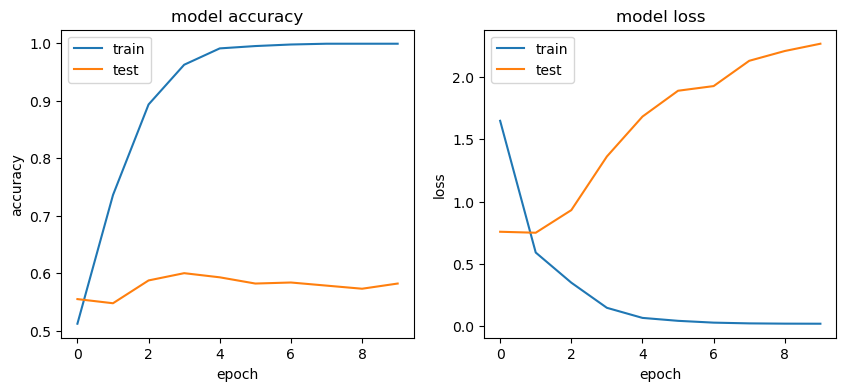

In [52]:
plotTrainingHistory(history)

In [25]:
history

# On prédit sur l'ensemble de test

# On prédit sur les données de test
y_hat = model.predict(x_test)

# On tranforme les prédictions en labels
i_pos = [i for i in range(len(y_hat)) if y_hat[i]>0]
i_neg = [i for i in range(len(y_hat)) if y_hat[i]<=0]

y_pred   = np.zeros(len(y_hat))
y_pred[i_pos] = 1
y_pred[i_neg] = 0

93/93 [==============================] - 1s 11ms/step


In [26]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)


La matrice de confusion sur le jeu de test :
 [[ 239 1120]
 [ 145 1459]] 

L accuracy sur le jeu de test est :
 0.5730678366520419


In [57]:
from keras.models import Sequential
from keras.callbacks import History

class BaseModel(object):
    def __init__(self):

        """
        Constructor to initialize the ConvNet's architecture parameters.
        :param config: the JSON configuration namespace.
        :param dataset: the training and testing dataset.
        :return none
        :raises none
        """
        # ConvNet model.
        self.dl_model = Sequential()

        # History object, holds training history.
        self.history = History()

        # Evaluation scores.
        self.scores = []

        # Predicted class labels.
        self.predictions = np.array([])

        # Construct the ConvNet model.
        self.define_model()

        # Configure the ConvNet model.
        self.compile_model()

        # Train the ConvNet model using testing dataset.
        self.fit_model()

        # Evaluate the ConvNet model using testing dataset.
        self.evaluate_model()
        
        # Training time.
        self.train_time = 0

        # Predict the class labels of testing dataset.
        self.predict()
        return

In [61]:
class SimpleRNN(BaseModel):

    def __init__(self, config, x_train, y_train, x_test, y_test):

        super().__init__(config)
        self.config  = config
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        return

    def define_simpleRNN_model(self):
        self.dl_model = Sequential()
        self.dl_model.add(Embedding(self.config["num_words"], self.config["mbed_size"]))          # layer embedding
        self.dl_model.add(SimpleRNN(self.config["RNN_size"], self.config["return_sequences"]))    # layer RNN
        self.dl_model.add(Dropout(self.config["dropout_percentage"]))                             # layer Dropout
        self.dl_model.add(Dense(1))         
        self.dl_model.summary()
        return self.dl_model


    def compile_model(self):
        self.dl_model.compile(  loss = self.config["compile_loss"],
                                optimizer = self.config["compile_optimizer"],
                                metrics = [self.config["compile_metrics"]]
                             )
        #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    def fit_model(self):

        start_time = time.time()
        self.history = self.cnn_model.fit( x = x_train,
                                           y = y_train,
                                           batch_size = self.config["batch_size"],
                                           epochs = self.config["num_epochs"],
                                           verbose = self.config["fit_verbose"],
                                           validation_split = self.config["validation_split"]
                                        )
        
        #history = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2,verbose=0 ) # on entraine

        end_time = time.time()
        self.train_time = end_time - start_time
        print( "The model took %0.3f seconds to train.\n"%self.train_time )

        return
        
    def evaluate_model(self):
        self.scores = self.cnn_model.evaluate( x = x_test,
                                               y = y_test,
                                               verbose = self.config["evaluate_verbose"]
                                            )

        print("Test loss: ", self.scores[0])
        print("Test accuracy: ", self.scores[1])

        return

    def predict(self):
        y_hat = self.dl_model.predict( x = x_test,
                                                  verbose = self.config["predict_verbose"])
        
        # On prédit sur les données de test

        # On tranforme les prédictions en labels
        i_pos = [i for i in range(len(y_hat)) if y_hat[i]>0]
        i_neg = [i for i in range(len(y_hat)) if y_hat[i]<=0]

        y_pred   = np.zeros(len(y_hat))
        y_pred[i_pos] = 1
        y_pred[i_neg] = 0
        
        self.predictions = y_pred

        return
    
    def computeCM(self):
        # On calcule la matrice de confusion
        cm_test = confusion_matrix(self.y_test, self.predictions)
        print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')
    
    def computeAccuracy(self):
        # On calcul le score d accuracy
        acc_train=accuracy_score(y_test, self.predictions)
        print('L accuracy sur le jeu de test est :\n', acc_train)

In [63]:
config ={
    "num_words": 5000 ,
    "mbed_size": 128,
    "RNN_size": 28,
    "return_sequences": False,
    "dropout_percentage" : 0.25,
    
    "compile_loss": 'binary_crossentropy',
    "compile_optimizer": 'adam',
    "compile_metrics": 'accuracy',

    "batch_size": 64,
    "num_epochs": 10,
    "fit_verbose": True,
    "validation_split": 0.25,
    
    "evaluate_verbose": True,
    "predict_verbose": True,  
}



In [ ]:
# Construct, compile, train and evaluate the ConvNet Model.
simpleRNNmodel = SimpleRNN(config, x_train, y_train, x_test, y_test)